# Performance and Timing

This is the scikit-learn half of a comparison to TMVA's operation.

 - We use 10 trees to train
 - 100K events (presumably)
 - [Event Dumper Job](http://higgs.phys.washington.edu:8080/job/CalRatio2016/job/MVADumpTrainingTuples/18/).
 - [Training Job](http://higgs.phys.washington.edu:8080/job/CalRatio2016/job/JetMVAClassifierTraining/191/).
 

## Initalization

In [10]:
from bdt_training_scikit_tools import plot_training_performance, load_default_samples, test_train_samples, prep_samples, default_training, calc_performance

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
from math import sqrt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## Load data

In [2]:
all_events = load_default_samples("20")
training, testing = test_train_samples(all_events)

BIB: 100000 events
Multijet: 100000 events
Signal: 100000 events


## Run Training
Run the default training with these events

In [4]:
training_events, training_class, training_weight, training_eval_weight = prep_samples(training[0], training[1], training[2])
testing_events, testing_class, testing_weight, testing_eval_weight = prep_samples(testing[0], testing[1], testing[2])

In [5]:
%%time
bdt = default_training(training_events, training_weight, training_class)

Wall time: 42.8 s


## Performance Training Performance
Check to make sure the training worked well - there isn't an issue with over training, that the number of trees used were enough, etc.

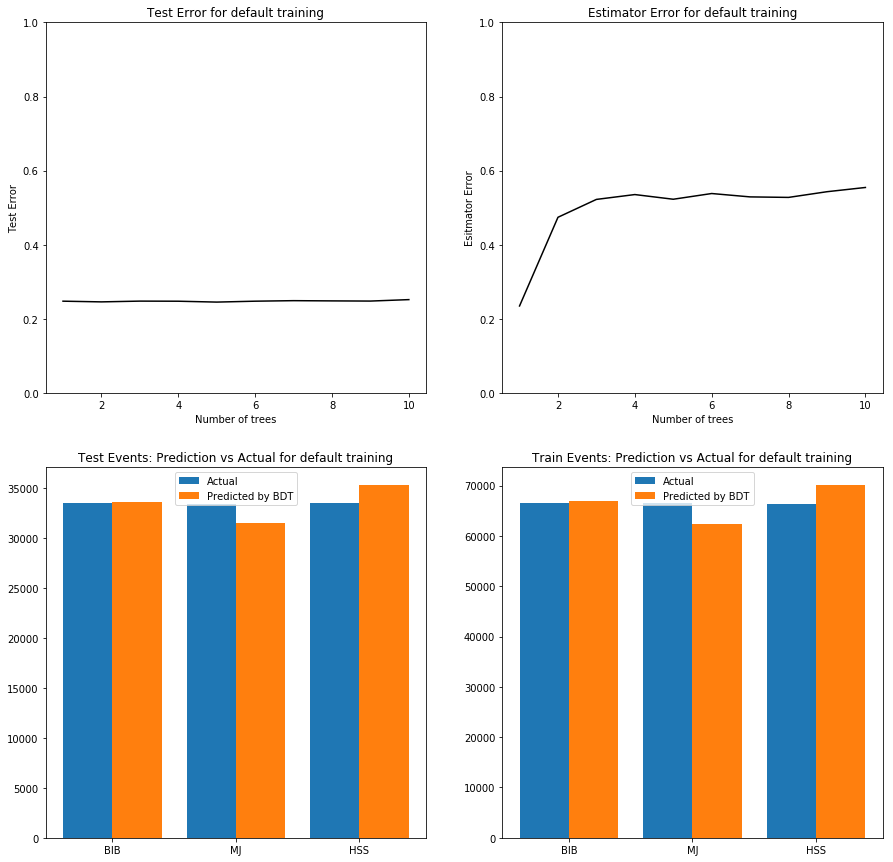

In [6]:
plot_training_performance(bdt, training, testing, "default")

## Seperation Performance
Look at how good this training is

In [7]:
d = calc_performance(bdt, testing)
pd.DataFrame({'DefaultTraining':d})

,DefaultTraining
BIBBack,2.115208e+07
BIBEff,6.190926e+02
BIBSsqrtB,4.705446e+00
BIBinBIB,2.164100e+04
BIBinHSS,2.281000e+03
BIBinMJ,9.587000e+03
HSSBack,2.323162e+06
HSSEff,9.385628e+02
HSSSsqrtB,2.106821e+01
HSSinBIB,9.910000e+02


# Performance Data from TMVA
Look at the data that has come back from a similar TMVA run.

# Loading Data

In [8]:
# Some defaults
data_location = "..\\..\\MCAResultsData"
jenkins_build = "192"
signal_sample_names=["125pi25lt5m", "200pi25lt5m", "400pi50lt5m", "600pi150lt5m", "1000pi400lt5m"]
bib_sample_names=["data15", "data16"]
mj_sample_names=["jz"]

def load_mva_data(sample_name):
    """Load the data written out by a MVA training job into an np array.
    Returns null if the csv file can't be found.
    
    Args:
      sample_name: The name of the sample, e.g. data15
    """
    p = "{0}\\{1}\\all-{2}.csv".format(data_location, jenkins_build, sample_name)
    if not os.path.exists(p):
        return None
    return pd.read_csv(p)

def load_mva_data_from_list(lst):
    """Load data for a series of samples. Silently ignore those we can't find
    
    Args:
        lst: List of samples to load
    """
    return {s[0] : s[1] for s in [(sname, load_mva_data(sname)) for sname in lst] if not(s[1] is None)}

In [11]:
signal_samples = load_mva_data_from_list(signal_sample_names)
bib_samples = load_mva_data_from_list(bib_sample_names)
mj_samples = load_mva_data_from_list(mj_sample_names)

## Determine the Performance
The TMVA multi-class isn't the same as the scikit-learn. TMVA gives us a probability. In some sense, what TMVA gies us is better than what scikit-learn gives us. None-the-less, to do the comparison we need to convert TMVA's output to something that looks like scikit-learn. We'll just take the largest value of the three weights, and that will determine the output type.

In [25]:
def convert_sample (sample):
    '''Convert from the TMVA values to scikit-learn values
    
    Args
        sample - the same DataFrame (with all the weights)
        
    Return
        df - A dataframe with an event weight column (Weight) and a class column (0, 1, 2 for bib, mj, and signal)
    '''
    itis_signal = (s.HSSWeight > s.MultijetWeight) & (s.HSSWeight > s.BIBWeight)
    itis_bib = (s.BIBWeight > s.MultijetWeight) & (s.BIBWeight > s.HSSWeight)
    itis_mj = (s.MultijetWeight > s.HSSWeight) & (s.MultijetWeight > s.BIBWeight)
    s_class = itis_mj*1 + itis_signal*2
    return pd.DataFrame({'Weight':s.Weight, 'PredClass':s_class})

signal_samples_skl = {k:convert_sample(signal_samples[k]) for k in signal_samples}
bib_samples_skl = {k:convert_sample(bib_samples[k]) for k in bib_samples}
mj_samples_skl = {k:convert_sample(mj_samples[k]) for k in mj_samples}

For the scikit-learn we had the signal all put together and the bib16 and the mj. So combine the signal here.